In [1]:
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)

import numpy as np 
import matplotlib.pyplot as plt 
from mmcv import Config

ignore_index = 255

import torch 


INSTANCE_COLOURS = np.asarray([
    [0, 0, 0],
    [255, 179, 0],
    [128, 62, 117],
    [255, 104, 0],
    [166, 189, 215],
    [193, 0, 32],
    [206, 162, 98],
    [129, 112, 102],
    [0, 125, 52],
    [246, 118, 142],
    [0, 83, 138],
    [255, 122, 92],
    [83, 55, 122],
    [255, 142, 0],
    [179, 40, 81],
    [244, 200, 0],
    [127, 24, 13],
    [147, 170, 0],
    [89, 51, 21],
    [241, 58, 19],
    [35, 44, 22],
    [112, 224, 255],
    [70, 184, 160],
    [153, 0, 255],
    [71, 255, 0],
    [255, 0, 163],
    [255, 204, 0],
    [0, 255, 235],
    [255, 0, 235],
    [255, 0, 122],
    [255, 245, 0],
    [10, 190, 212],
    [214, 255, 0],
    [0, 204, 255],
    [20, 0, 255],
    [255, 255, 0],
    [0, 153, 255],
    [0, 255, 204],
    [41, 255, 0],
    [173, 0, 255],
    [0, 245, 255],
    [71, 0, 255],
    [0, 255, 184],
    [0, 92, 255],
    [184, 255, 0],
    [255, 214, 0],
    [25, 194, 194],
    [92, 0, 255],
    [220, 220, 220],
    [255, 9, 92],
    [112, 9, 255],
    [8, 255, 214],
    [255, 184, 6],
    [10, 255, 71],
    [255, 41, 10],
    [7, 255, 255],
    [224, 255, 8],
    [102, 8, 255],
    [255, 61, 6],
    [255, 194, 7],
    [0, 255, 20],
    [255, 8, 41],
    [255, 5, 153],
    [6, 51, 255],
    [235, 12, 255],
    [160, 150, 20],
    [0, 163, 255],
    [140, 140, 140],
    [250, 10, 15],
    [20, 255, 0],
])


def generate_instance_colours(instance_map):
    # Most distinct 22 colors (kelly colors from https://stackoverflow.com/questions/470690/how-to-automatically-generate
    # -n-distinct-colors)
    # plus some colours from AD40k

    return {instance_id: INSTANCE_COLOURS[global_instance_id % len(INSTANCE_COLOURS)] for
            instance_id, global_instance_id in instance_map.items()
            }

def plot_instance_map(instance_image, instance_map, instance_colours=None, bg_image=None):
    if isinstance(instance_image, torch.Tensor):
        instance_image = instance_image.cpu().numpy()
    assert isinstance(instance_image, np.ndarray)
    if instance_colours is None:
        instance_colours = generate_instance_colours(instance_map)
    if len(instance_image.shape) > 2:
        instance_image = instance_image.reshape(
            (instance_image.shape[-2], instance_image.shape[-1]))

    # white background + colorful objects
    if bg_image is None:
        plot_image = 255 * \
            np.ones(
                (instance_image.shape[0], instance_image.shape[1], 3), dtype=np.uint8)
    else:
        plot_image = bg_image

    for key, value in instance_colours.items():
        plot_image[instance_image == key] = value

    return plot_image



from projects.mmdet3d_plugin.datasets.utils.warper import FeatureWarper
import os


def import_modules_load_config(cfg_file="beverse_tiny.py", samples_per_gpu=1):
    cfg_path = r"/home/niklas/ETM_BEV/BEVerse/projects/configs"
    cfg_path = os.path.join(cfg_path, cfg_file)

    cfg = Config.fromfile(cfg_path)

    # if args.cfg_options is not None:
    #     cfg.merge_from_dict(args.cfg_options)
    # import modules from string list.
    if cfg.get("custom_imports", None):
        from mmcv.utils import import_modules_from_strings

        import_modules_from_strings(**cfg["custom_imports"])

    # import modules from plguin/xx, registry will be updated
    if hasattr(cfg, "plugin"):
        if cfg.plugin:
            import importlib

            if hasattr(cfg, "plugin_dir"):
                plugin_dir = cfg.plugin_dir
                _module_dir = os.path.dirname(plugin_dir)
                _module_dir = _module_dir.split("/")
                _module_path = _module_dir[0]

                for m in _module_dir[1:]:
                    _module_path = _module_path + "." + m
                print(_module_path)
                plg_lib = importlib.import_module(_module_path)
            else:
                # import dir is the dirpath for the config file
                _module_dir = cfg_path
                _module_dir = _module_dir.split("/")
                _module_path = _module_dir[0]
                for m in _module_dir[1:]:
                    _module_path = _module_path + "." + m
                print(_module_path)
                plg_lib = importlib.import_module(_module_path)

    samples_per_gpu = 1
    if isinstance(cfg.data.test, dict):
        cfg.data.test.test_mode = True
        samples_per_gpu = cfg.data.test.pop("samples_per_gpu", 1)
        if samples_per_gpu > 1:
            # Replace 'ImageToTensor' to 'DefaultFormatBundle'
            cfg.data.test.pipeline = replace_ImageToTensor(
                cfg.data.test.pipeline)
    elif isinstance(cfg.data.test, list):
        for ds_cfg in cfg.data.test:
            ds_cfg.test_mode = True
        samples_per_gpu = max(
            [ds_cfg.pop("samples_per_gpu", 1) for ds_cfg in cfg.data.test]
        )
        if samples_per_gpu > 1:
            for ds_cfg in cfg.data.test:
                ds_cfg.pipeline = replace_ImageToTensor(ds_cfg.pipeline)

    return cfg


torch.backends.cudnn.benchmark = True

cfg = import_modules_load_config(
    cfg_file=r"beverse_tiny_org.py")






projects.mmdet3d_plugin


In [2]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
    dataset,
    samples_per_gpu=1,
    workers_per_gpu=cfg.data.workers_per_gpu,
    dist=False,
    shuffle=False)


grid_conf = {
    "xbound": [-50.0, 50.0, 0.5],
    "ybound": [-50.0, 50.0, 0.5],
    "zbound": [-10.0, 10.0, 20.0],
    "dbound": [1.0, 60.0, 1.0],
}

warper = FeatureWarper(grid_conf=grid_conf)


In [3]:
iter_loader =iter(data_loader)


In [4]:
sample = next(iter_loader)


In [28]:
import math
import torch.nn.functional as F 


class pseud_class:
    def __init__(self) -> None:
        
        self.receptive_field = 4
        self.warper = FeatureWarper(grid_conf=grid_conf)
        self.ignore_index = 255
    def prepare_targets(self, batch,bev_size = (200,200), mask_stride=2,match_stride=2):
        segmentation_labels = batch["motion_segmentation"][0]
        gt_instance = batch["motion_instance"][0]
        future_egomotion = batch["future_egomotions"][0]
        batch_size = len(segmentation_labels)
        labels = {}

        bev_transform = batch.get("aug_transform", None)
        labels["img_is_valid"] = batch.get("img_is_valid", None)

        if bev_transform is not None:
            bev_transform = bev_transform.float()
        #warping so all segmentation labels are inside the current BEV frame FIERY reports better convergence / performance if you do this 
        segmentation_labels = (
            self.warper.cumulative_warp_features_reverse(
                segmentation_labels.float().unsqueeze(2),
                future_egomotion[:, (self.receptive_field - 1) :],
                mode="nearest",
                bev_transform=bev_transform,
            )
            .long()
            .contiguous()
        ).squeeze().to(torch.float32)
        #print(f"Seg labels shape: {segmentation_labels.shape =}")

        target_list = []
        for b in range(batch_size):
            gt_list = []
            #gt_instance[b] = gt_instance[b][gt_instance[b]!=self.ignore_index]
            ids = gt_instance[b].unique()

            ids = ids[ids != self.ignore_index]
            ids = ids[ids != 0]
            
            label_t_list = []
            for t in gt_instance[b]:
                t_labels = t.unique()
                t_labels = t_labels[t_labels != self.ignore_index]
                t_labels = t_labels[t_labels != 0]
                label_t_list.append(len(t_labels))

            for _id in ids:
                test_bool = torch.where(
                    gt_instance[b] == _id, 1., 0.)
                gt_list.append(test_bool)

            segmentation_labels = torch.stack(gt_list, dim=0)

            #segmentation_labels = torch.stack(gt_batch_instances_list,dim=0)
            o_h, o_w = segmentation_labels.shape[-2:]
            l_h, l_w = math.ceil(o_h/mask_stride), math.ceil(o_w/mask_stride)
            m_h, m_w = math.ceil(o_h/match_stride), math.ceil(o_w/match_stride)

            gt_masks_for_loss = F.interpolate(segmentation_labels, size=(
                l_h, l_w), mode="bilinear", align_corners=False)
            gt_masks_for_match = F.interpolate(segmentation_labels, size=(
                m_h, m_w), mode="bilinear", align_corners=False)

            # labels only continous for clip - this is much more of an tracking id as every class is a vehicle anyways # TODO make work with other types of superclasses other then vehicle
            #ids = gt_instance[b].unique()
            # print(
            #     f"Labels over {len(gt_instance[b])} for Batch {b+1}, no.labels {label_t_list} no.masks {gt_masks_for_match.shape}")
            target_list.append({"labels": ids, "masks": segmentation_labels,
                               "match_masks": segmentation_labels, "gt_motion_instance": gt_instance[b]})
        return target_list, future_egomotion[:, (self.receptive_field - 1):]


In [31]:
len(sample["semantic_map"][0])

2

In [6]:
segmentation_labels = sample["motion_segmentation"][0].to(torch.float32)

o_h, o_w = (200,200)
l_h, l_w = math.ceil(o_h/2), math.ceil(o_w/2)
m_h, m_w = math.ceil(o_h/2), math.ceil(o_w/2)
gt_masks_for_loss  = F.interpolate(segmentation_labels, size=(l_h, l_w), mode="bilinear", align_corners=False)
gt_masks_for_match = F.interpolate(segmentation_labels, size=(m_h, m_w), mode="bilinear", align_corners=False)

In [38]:
gt_masks_for_loss.shape

torch.Size([2, 4, 100, 100])

In [29]:
p = pseud_class()
target_list = p.prepare_targets(sample)

In [30]:
target_list=target_list[0][0]
target_list["labels"]


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [9]:
target_list["masks"].shape


torch.Size([14, 5, 100, 100])

In [31]:
motion_masks=target_list["masks"]


In [22]:
motion_masks=motion_masks.permute(1,0,2,3)

In [32]:
motion_masks.shape

torch.Size([14, 5, 200, 200])

In [33]:
motion_masks = motion_masks[:5]
motion_masks.shape

torch.Size([5, 5, 200, 200])

In [34]:
motion_masks=motion_masks.permute(1,0,2,3)

In [35]:
t1_motion_masks = motion_masks[0]
t1_motion_masks.shape

torch.Size([5, 200, 200])

In [37]:
t1_motion_masks.unique()

tensor([0., 1.])

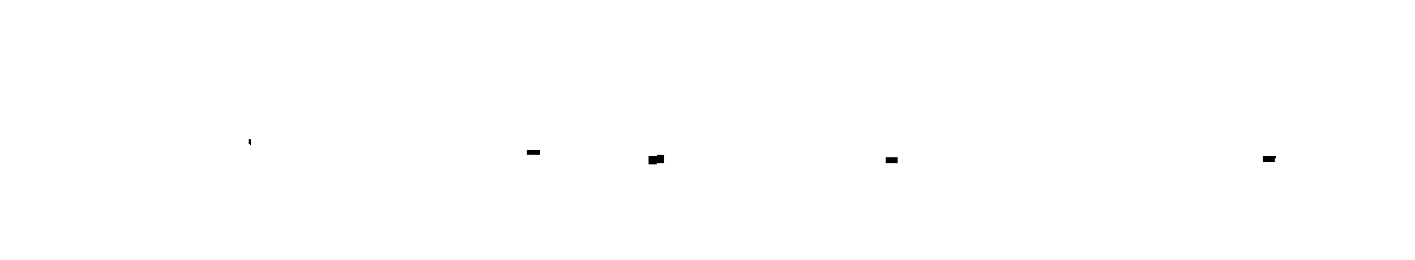

In [36]:
num_instances = t1_motion_masks.shape[0]
plt.figure(0, figsize=(18, 4))
for i in range(num_instances):
    plt.subplot(1, num_instances, i + 1)
    plt.imshow(t1_motion_masks[i])
    plt.axis('off')
    
plt.savefig(
                f'/home/niklas/ETM_BEV/VIS/viz/t1_motion_masks.png')


(-0.5, 199.5, 199.5, -0.5)

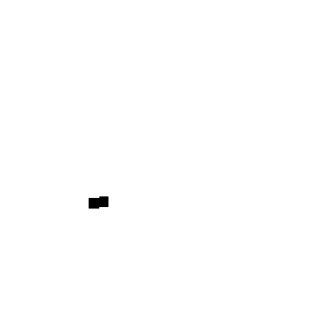

In [54]:

plt.figure(0, figsize=(18, 4))
plt.imshow(t1_motion_masks[2].numpy())
plt.axis('off')

In [24]:
gt_instance = target_list["gt_motion_instance"]
gt_instance.shape

torch.Size([5, 200, 200])

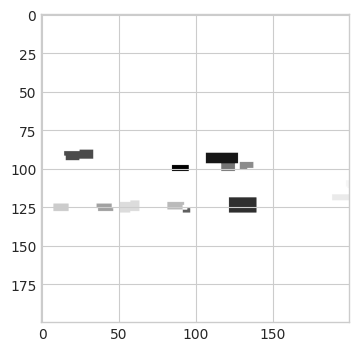

In [25]:
plt.figure(0, figsize=(18, 4))
plt.imshow(gt_instance[0])


In [38]:
test_bool = torch.where(
    gt_instance[0] == 0, 1., 0.)


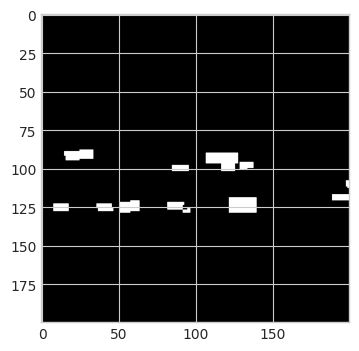

In [39]:
plt.figure(0, figsize=(18, 4))
plt.imshow(test_bool)
plt.axis('off')
plt.savefig(
                    f'/home/niklas/ETM_BEV/VIS/viz/test_bool{0}.png')



In [70]:
len(sample["motion_instance"][0][1].unique())

25

In [12]:

gt_instances = sample["motion_instance"][0]
#print(f"{gt_instance.shape = }")
future_egomotion = sample["future_egomotions"][0]
bev_transform = sample.get("aug_transform", None)
receptive_field = 4

gt_instance = (
    warper.cumulative_warp_features_reverse(
        gt_instances.float().unsqueeze(2),
        future_egomotion[:, (receptive_field - 1):],
        mode="nearest",
        bev_transform=bev_transform,
    )
    .long()
    .contiguous()[:, :, 0]
)

temporal_instances = gt_instance[0]
num_frame = temporal_instances.shape[0]
temporal_instances_real = gt_instance[0].clone()


instance_ids = np.unique(temporal_instances_real)[1:]
instance_ids = instance_ids[instance_ids != ignore_index]
print(instance_ids)
instance_map = dict(zip(instance_ids, instance_ids))

#num_frame = 1
temporal_instances[temporal_instances != 5] = 0

plt.figure(0, figsize=(18, 4))
for i in range(num_frame):
    color_instance_i = plot_instance_map(
        temporal_instances[i], instance_map)
    plt.subplot(1, num_frame, i + 1)
    plt.imshow(color_instance_i)
    plt.axis('off')
    plt.show()
plt.figure(0, figsize=(18, 4))
for i in range(num_frame):
    color_instance_i = plot_instance_map(
        temporal_instances_real[i], instance_map)
    plt.subplot(1, num_frame, i + 1)
    plt.imshow(color_instance_i)
    plt.axis('off')

    # plt.savefig(
    #     f'{"/home/niklas/ETM_BEV/BEVerse/viz"}/temporal_instanceswarped_{i}.png')
    plt.show()


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


KeyboardInterrupt: 

In [125]:
sample = next(iter_loader)


[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 32 34 35]


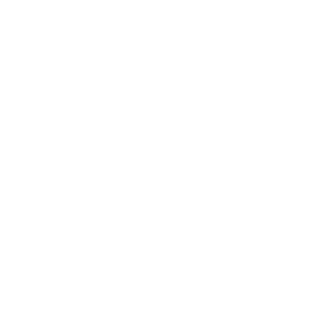

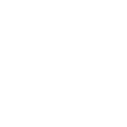

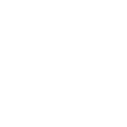

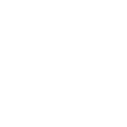

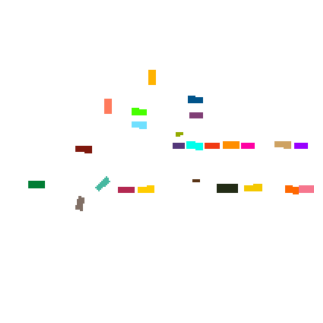

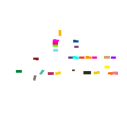

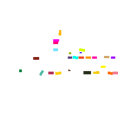

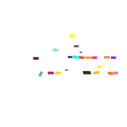

In [127]:
sample = next(iter_loader)
gt_instances = sample["motion_instance"][0]
#print(f"{gt_instance.shape = }")
future_egomotion = sample["future_egomotions"][0]
bev_transform = sample.get("aug_transform", None)
receptive_field = 4

gt_instance = (
    warper.cumulative_warp_features_reverse(
        gt_instances.float().unsqueeze(2),
        future_egomotion[:, (receptive_field - 1):],
        mode="nearest",
        bev_transform=bev_transform,
    )
    .long()
    .contiguous()[:, :, 0]
)

temporal_instances = gt_instance[0]
num_frame = temporal_instances.shape[0]
temporal_instances_real = gt_instance[0].clone()


instance_ids = np.unique(temporal_instances_real)[1:]
instance_ids = instance_ids[instance_ids != ignore_index]
print(instance_ids)
instance_map = dict(zip(instance_ids, instance_ids))

#num_frame = 1
temporal_instances[temporal_instances != 5] = 0

plt.figure(0, figsize=(18, 4))
for i in range(num_frame):
    color_instance_i = plot_instance_map(
        temporal_instances[i], instance_map)
    plt.subplot(1, num_frame, i + 1)
    plt.imshow(color_instance_i)
    plt.axis('off')
    plt.show()
plt.figure(0, figsize=(18, 4))
for i in range(num_frame):
    color_instance_i = plot_instance_map(
        temporal_instances_real[i], instance_map)
    plt.subplot(1, num_frame, i + 1)
    plt.imshow(color_instance_i)
    plt.axis('off')

    # plt.savefig(
    #     f'{"/home/niklas/ETM_BEV/BEVerse/viz"}/temporal_instanceswarped_{i}.png')
    plt.show()


In [85]:
sample.keys()

dict_keys(['img_metas', 'img_inputs', 'semantic_indices', 'semantic_map', 'future_egomotions', 'gt_bboxes_3d', 'gt_labels_3d', 'motion_segmentation', 'motion_instance', 'instance_centerness', 'instance_offset', 'instance_flow', 'has_invalid_frame', 'img_is_valid'])

In [9]:
temporal_instances = sample['motion_instance'][0]
num_frame = temporal_instances.shape[0]


1


In [19]:
temporal_instances.shape

torch.Size([1, 4, 200, 200])

In [10]:
instance_ids = np.unique(temporal_instances)[1:]


In [11]:
instance_ids


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])

In [13]:
instance_ids = instance_ids[instance_ids != ignore_index]
instance_ids


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])

In [15]:
instance_map = dict(zip(instance_ids, instance_ids))
instance_map


{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21}

In [20]:
temporal_instances[0].shape

torch.Size([4, 200, 200])

In [23]:
sample.keys()


dict_keys(['img_metas', 'img_inputs', 'semantic_indices', 'semantic_map', 'future_egomotions', 'gt_bboxes_3d', 'gt_labels_3d', 'motion_segmentation', 'motion_instance', 'instance_centerness', 'instance_offset', 'instance_flow', 'has_invalid_frame', 'img_is_valid'])

In [77]:
sample["instance_flow"][0].shape


torch.Size([1, 4, 2, 200, 200])

In [79]:
out = sample["instance_flow"][0].reshape(
    (4, 2, sample["instance_flow"][0].shape[-2], sample["instance_flow"][0].shape[-1])).clone()


torch.Size([4, 2, 200, 200])

In [81]:
np.unique(out[0])[1:]


array([  0.,   1.,   2.,   4., 255.], dtype=float32)

In [68]:
int_out = out.to(torch.int16).numpy()

In [59]:
out.shape

torch.Size([3, 200, 400])

In [61]:
int_out.shape

(3, 200, 400)

In [69]:
c = 1
for i in range(len(int_out)):
    int_out[i] = int_out[i]*c
    c +=1
np.unique(int_out)

array([0, 1, 2, 3, 4], dtype=int16)

In [53]:
int_out.shape

(2,)

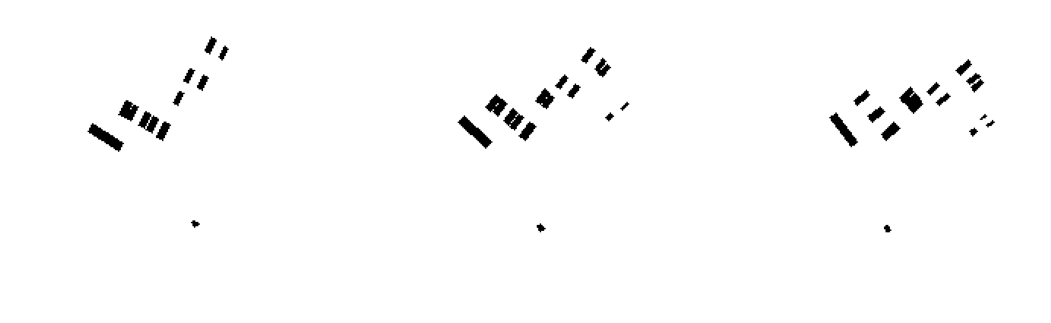

In [70]:
plt.figure(0, figsize=(18, 4))
for i in range(3):
    plt.subplot(1, num_frame, i + 1)
    plt.imshow(int_out[i])
    plt.axis('off')


In [22]:
temporal_instances = sample['motion_instance'][0][0]
num_frame = temporal_instances.shape[0]

instance_ids = np.unique(temporal_instances)[1:]
instance_ids = instance_ids[instance_ids != ignore_index]
instance_map = dict(zip(instance_ids, instance_ids))

plt.figure(0, figsize=(18, 4))
for i in range(num_frame):
    color_instance_i = plot_instance_map(
        temporal_instances[i], instance_map)
    plt.subplot(1, num_frame, i + 1)
    plt.imshow(color_instance_i)
    plt.axis('off')

plt.savefig(
    '{}/temporal_instances.png'.format(r'/home/niklas/ETM_BEV/BEVerse/viz'))
plt.close()


In [93]:
type(bev_transform)


NoneType

In [89]:
gt_instances.shape


torch.Size([1, 4, 200, 200])

In [88]:
gt_instances.float().unsqueeze(2).shape


torch.Size([1, 4, 1, 200, 200])

In [92]:
future_egomotion[0][:, (receptive_field - 1):].shape


torch.Size([1, 4, 6])

In [111]:
temporal_instances = sample['motion_instance'][0][0]
num_frame = temporal_instances.shape[0]

instance_ids = np.unique(temporal_instances)[1:]
instance_ids = instance_ids[instance_ids != ignore_index]
instance_map = dict(zip(instance_ids, instance_ids))


for i in range(num_frame):
    plt.figure(0, figsize=(18, 4))
    color_instance_i = plot_instance_map(
        temporal_instances[i], instance_map)
    #plt.subplot(1, num_frame, i + 1)
    plt.imshow(color_instance_i)
    plt.axis('off')
    plt.savefig(
        f'/home/niklas/ETM_BEV/BEVerse/viz/temporal_instances_not_warped_{i}.png')
    plt.close()


In [101]:
temporal_instances.shape

torch.Size([1, 4, 200, 200])

In [102]:
gt_instance.shape

torch.Size([1, 4, 200, 200])

1